In [6]:

from __future__ import print_function

import datetime
import numpy as np
import pandas as pd

from Backtest.strategy import Strategy
from Backtest.event import SignalEvent
from Backtest.event import EventType
from Backtest.backtest import Backtest
from Backtest.data import JSONDataHandler
import queue



class MACDStrategy(Strategy):
    def __init__(self, bars, events, suggested_quantity = 1,
                 short_window = 10, long_window = 40):
        self.bars = bars
        self.symbol_list = self.bars.tickers
        self.events = events
        self.suggested_quantity = suggested_quantity
        self.holdinds = self._calculate_initial_holdings()

        self.short_window = short_window
        self.long_window = long_window
        
        self.short_ma = pd.Series(0.0, index = bars.times)
        self.long_ma = pd.Series(0.0, index = bars.times)

    def _calculate_initial_holdings(self):
        holdings = {}
        for s in self.symbol_list:
            holdings[s] = "EMPTY"
        return holdings

    def generate_signals(self, event):
        if event.type == EventType.MARKET:
            ticker = event.ticker
            bars = self.bars.get_latest_bars_values(
                ticker, "close", N=self.long_window
            )
            bar_date = event.timestamp
            if bars is not None and bars != []:
                short_ma = np.mean(bars[-self.short_window:])
                long_ma  = np.mean(bars[-self.long_window:])
                
                self.short_ma[bar_date] = short_ma
                self.long_ma[bar_date] = long_ma

                if short_ma > long_ma and self.holdinds[ticker] == "EMPTY":
                    print("LONG: %s" % bar_date)
                    signal = SignalEvent(ticker, "LONG", self.suggested_quantity)
                    self.events.put(signal)
                    self.holdinds[ticker] = "HOLD"
                elif short_ma < long_ma and self.holdinds[ticker] == "HOLD":
                    print("SHORT: %s" % bar_date)
                    signal = SignalEvent(ticker, "SHORT", self.suggested_quantity)
                    self.events.put(signal)
                    self.holdinds[ticker] = "EMPTY"


In [7]:
def run(config, short_window = 10, long_window = 40):
    events_queue = queue.Queue()
    data_handler = JSONDataHandler(
        config['csv_dir'], config['freq'], events_queue, config['tickers'],
        start_date=config['start_date'], end_date=config['end_date']
    )
    strategy = MACDStrategy(data_handler, events_queue, suggested_quantity = 1,
                            short_window = 10, long_window = 40)

    backtest = Backtest(config, events_queue, strategy,
                        data_handler= data_handler)

    backtest.start_trading(config)

In [8]:

config = {
    "csv_dir": "F:/Python/backtest/backtest/ethusdt-trade.csv.2018-07-25.formatted",
    "out_dir": "C:\\Users\\user\\out\\",
    "title": "MACDStrategy",
    "save_plot": False,
    "save_tradelog": False,
    "start_date": pd.Timestamp("2018-07-25T00:00:00", tz = "UTC"),
    "end_date": pd.Timestamp("2018-07-25T06:20:00", tz = "UTC"),
    "equity": 500.0,
    "freq": 1,      # min
    "tickers": ['ETHUSDT']
}

Start Date: 2018-07-25 00:00:00+00:00
End Date: 2018-07-25 06:20:00+00:00
Running Backtest...
---------------------------------
LONG: 2018-07-25 00:10:00+00:00
SHORT: 2018-07-25 00:38:00+00:00
LONG: 2018-07-25 01:19:00+00:00
SHORT: 2018-07-25 01:43:00+00:00
LONG: 2018-07-25 01:49:00+00:00
SHORT: 2018-07-25 02:12:00+00:00


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


LONG: 2018-07-25 03:39:00+00:00
SHORT: 2018-07-25 05:22:00+00:00
LONG: 2018-07-25 05:48:00+00:00
SHORT: 2018-07-25 06:04:00+00:00
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.2437135380
Max Drawdown: 1.1091051321
Max Drawdown Duration: 258
Total Returns: 0.0033200000


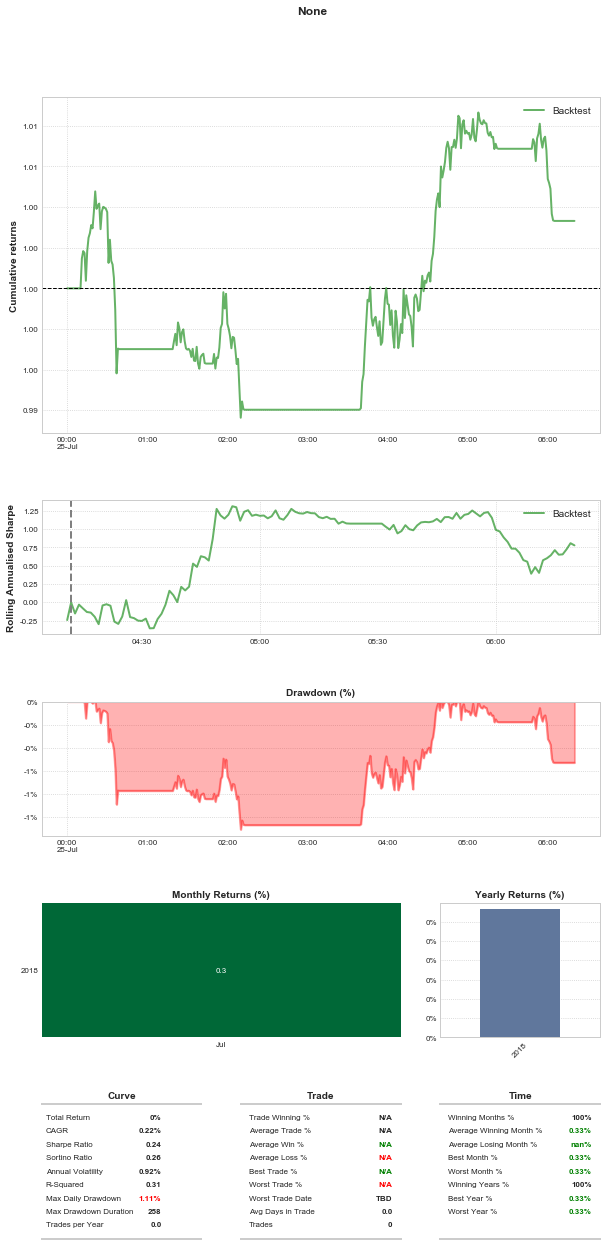

In [9]:

run(config, short_window = 10, long_window = 40)

In [ ]:
for i in range()